In [1]:
import base64
from IPython.display import HTML
import json
import pandas as pd
import os
import sys
import time
import datetime
from IPython.display import Markdown
import matplotlib.pyplot as plt

In [2]:
def durationWithUnit(timeOrCount, type):
    durationWithUnit=str(timeOrCount)
    if batch['Tests']['type']=='duration':
        return durationWithUnit+ ' sec'
    else:
        return durationSingleTest + ' requests'

In [3]:
def create_download_link( df, title = "Download CSV file", filename = "data.csv"):
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [4]:
def addCommonData(resultData):
    resultData['Deployment']=deployment
    resultData['Total CPUs']=totalCPUs
    resultData['Total Memory GB']=totalMemoryGB
    resultData['Duration Single Test']=durationSingleTest
    resultData['Persistence']=persistence
    resultData['App Process URL']=appProcessUrl

In [5]:
batch=json.load(open('test-run/batch.json'))
# print(batch)

In [6]:
# TODO: restore once usage is available
# systemDataName='test-run/results/system-data.csv'
# #  systemDataName='system-data.csv'
# systemData = pd.read_csv(systemDataName, names=['javaversion', 'totalCPUs', 'totalMemoryGB'],header=0, index_col=False)
# totalCPUs=systemData.totalCPUs[0]
# totalMemoryGB=systemData.totalMemoryGB[0]
totalCPUs='NA'
totalMemoryGB='NA'

In [7]:
tester=batch['InfraSetup']['tester']
app=batch['InfraSetup']['app']
localHosts=['LOCAL','VM1','VM2']
deployment='On-premise' if (tester['name'] in localHosts and app['name'] in localHosts) else 'Cloud'
repeats=batch['Tests']['repeats']
appInfra=batch['AppInfra']
persistence='Mongo' if appInfra['Mongo']=='yes' else 'PostgresQL' if appInfra['PostgresQL']=='yes' else 'None'
appProcess=batch['Process']
appProcessUrl=appProcess['schema']+"://"+appProcess['url']+':'+str(appProcess['port'])+'/'+appProcess['app']

durationSingleTest=durationWithUnit(batch['Tests']['timeOrCount'], batch['Tests']['type'])

# TODO: can we fetch this together with the CPU/Memory system details?
jdkVersion='openjdk 11.0.10 2021-01-19'
# TODO: do we want to model test engin in batch.json?
testEngine='Quarkus Client'

warmup='no' if batch['Warmup']=="no" else durationWithUnit(batch['Warmup']['timeOrCount'], batch['Warmup']['type'])


In [8]:
testResults=[]
minTimestamp=sys.maxsize
maxTimestamp=0
repeats=batch['Tests']['repeats']
round=1
while round <= repeats:
    for test in batch['Tests']['runs']:
        folderName='test-run/test-'+str(round)+'-'+str(test['replicas'])+'-'+str(test['users'])
        csvName=folderName+'/res.csv'
        result = pd.read_csv(csvName, header=0, index_col=False)
        # print(result)
        resultData={}
        addCommonData(resultData)
        resultData['#Replicas']=str(round)+'-'+str(test['replicas'])
        resultData['#Users']=test['users']
        resultData['MRT(ms)']=result.Average[0]
        resultData['RPS']=result.Throughput[0]
        resultData['Failures%']=result['Error %'][0]
        # print(resultData)


        usageName=folderName+'/metrics.csv'
        # usageName='usageN.csv'
        usage = pd.read_csv(usageName, 
            names=['kogitoCpuUsage', 'kogitoMemoryUsage', 'mongoCpuUsage', 'mongoMemoryUsage'],
            header=0, index_col=False)
        # resultData['CPU Usage-app']=usage.appCpuUsage[0]
        resultData['Kogito CPU Usage']=usage.kogitoCpuUsage[0]
        resultData['Mongo CPU Usage']=usage.mongoCpuUsage[0]
        # resultData['Memory Usage%-app']=usage.appMemoryUsagePercentage[0]
        resultData['Kogito Memory Usage']=usage.kogitoMemoryUsage[0]
        resultData['Mongo Memory Usage']=usage.mongoMemoryUsage[0]
        # resultData['Memory Usage%-system']=usage.systemMemoryUsagePercentage[0]

        # print(resultData)
        testResults.append(resultData)

        # jtlName='test-run/results/res'+str(counter)+'.jtl'
        # jtl = pd.read_csv(jtlName, header=0, index_col=False)
        minTimestamp=min([minTimestamp, os.stat(csvName).st_birthtime])
        maxTimestamp=max([maxTimestamp, os.stat(csvName).st_mtime])
    round = round+1
    
# print(testResults)

In [9]:
startTime=time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(minTimestamp))
endTime=time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(maxTimestamp))
batchDuration=str(datetime.timedelta(seconds=(maxTimestamp-minTimestamp)))

In [10]:
Markdown("""
# Kogito Benchmart Report
## Test Environment
* Deployment:  {deployment}
* Execution time: Started {startTime}, ended {endTime})
* Duration:  {batchDuration}
* Test rounds:  {repeats}
* Duration of each test:  {durationSingleTest}
* Warmup: {warmup}
* Persistence: {persistence}
* Process: {appProcessUrl}
""".format(startTime=startTime, 
    endTime=endTime,batchDuration=batchDuration, repeats=repeats,
    deployment=deployment, durationSingleTest=durationSingleTest, warmup=warmup,
    persistence=persistence, appProcessUrl=appProcessUrl))




# Kogito Benchmart Report
## Test Environment
* Deployment:  Cloud
* Execution time: Started 2021-11-05 17:54:16, ended 2021-11-05 18:47:46)
* Duration:  0:53:30.303705
* Test rounds:  6
* Duration of each test:  120 sec
* Warmup: 20 sec
* Persistence: Mongo
* Process: http://localhost:8080/simpleHT


In [11]:
Markdown("""
## Test Client
* Client host: {hostname}
* Test engine:  {testEngine}
""".format(hostname=tester['hostname'], testEngine=testEngine, durationSingleTest=durationSingleTest))


## Test Client
* Client host: https://console-openshift-console.apps.kogito-ocp.hib9.p1.openshiftapps.com
* Test engine:  Quarkus Client


In [12]:
props=batch['ProcessProperties']
md=''
if len(props) > 0:
    md='**Additional properties:**'
    for p in props:
        md = md+f'\n* {p["key"]} = {p["val"]}'
Markdown(md)

**Additional properties:**
* quarkus.vertx.worker-pool-size = 10
* quarkus.mongodb.min-pool-size = 10
* quarkus.mongodb.max-pool-size = 10

In [13]:
comments=batch['Comments']
md=''
if len(comments) > 0:
    md='**Additional comments:**'
    for p in comments:
        md = md+f'\n* {p}'
Markdown(md)

**Additional comments:**
* {'limits': {'cpu': '500m', 'memory': '500Mi'}, 'requests': {'cpu': '500m', 'memory': '500Mi'}}
* {'limits': {'cpu': '1', 'memory': '500M'}, 'requests': {'cpu': '500m', 'memory': '400M'}}

In [14]:
Markdown("""
## Test Service
* Service host: {hostname} ({totalCPUs} CPU cores, {totalMemoryGB} GB Memory)
* Test engine:  {testEngine}
* JDK version:  {jdkVersion}
* Kogito version: {appVersion}
""".format(hostname=app['hostname'], totalCPUs=totalCPUs, totalMemoryGB=totalMemoryGB,
    testEngine=testEngine, jdkVersion=jdkVersion,
    appVersion=batch['InfraSetup']['appVersion']))



## Test Service
* Service host: https://console-openshift-console.apps.kogito-ocp.hib9.p1.openshiftapps.com (NA CPU cores, NA GB Memory)
* Test engine:  Quarkus Client
* JDK version:  openjdk 11.0.10 2021-01-19
* Kogito version: kogito-1.13.0.Final


## Execution Report
### Chart view

In [15]:
raw = pd.DataFrame(testResults)
# print(raw)
# raw.style

In [16]:
raw.insert(1,'Start Time', startTime)
raw.insert(2,'End Time', endTime)
raw.insert(3,'Batch Duration', batchDuration)


In [17]:
users = raw['#Users'].unique()
# print(users)

In [18]:
mrt = {}
for r in raw['#Replicas'].unique():
    mrtValues = raw[raw['#Replicas']==r]['MRT(ms)'].values
    mrt['MRT#'+str(r)] = mrtValues
# print(mrt)

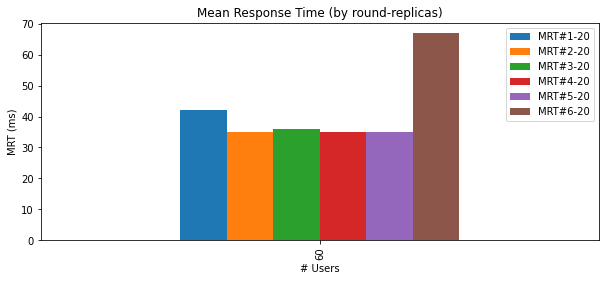

In [19]:
plt.rcParams["figure.figsize"] = (10,4)

mrtDF = pd.DataFrame(mrt, index=users)

mrtDF.plot(kind="bar")
plt.title("Mean Response Time (by round-replicas)")
plt.xlabel("# Users")
plt.ylabel("MRT (ms)")
plt.rcParams["figure.figsize"] = (10,4)


In [20]:
rps = {}
for r in raw['#Replicas'].unique():
    rpsValues = raw[raw['#Replicas']==r]['RPS'].values
    rps['RPS#'+str(r)] = rpsValues

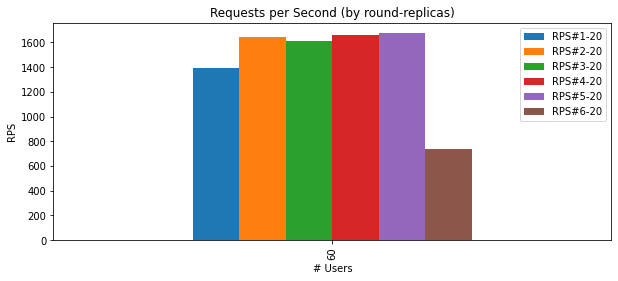

In [21]:
rpsDF = pd.DataFrame(rps, index=users)

rpsDF.plot(kind="bar")
plt.title("Requests per Second (by round-replicas)")
plt.xlabel("# Users")
plt.ylabel("RPS")
plt.rcParams["figure.figsize"] = (10,4)

In [36]:
failures = {}
for r in raw['#Replicas'].unique():
    failuresValues = raw[raw['#Replicas']==r]['Failures%'].values
    failures['Failures#'+str(r)] = failuresValues

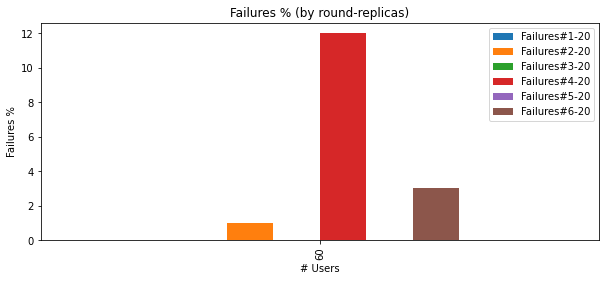

In [37]:
failuresDF = pd.DataFrame(failures, index=users)

failuresDF.plot(kind="bar")
plt.title("Failures % (by round-replicas)")
plt.xlabel("# Users")
plt.ylabel("Failures %")
plt.rcParams["figure.figsize"] = (10,4)

In [24]:
cpuUsage = {}
for r in raw['#Replicas'].unique():
    kogitoCpuUsageValues = raw[raw['#Replicas']==r]['Kogito CPU Usage'].values
    cpuUsage['Kogito CPU#'+str(r)] = kogitoCpuUsageValues


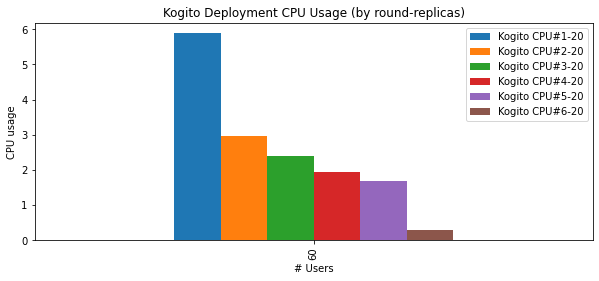

In [25]:
cpusDF = pd.DataFrame(cpuUsage, index=users)
# cpusDF.style
cpusDF.plot(kind="bar")
plt.title("Kogito Deployment CPU Usage (by round-replicas)")
plt.xlabel("# Users")
plt.ylabel("CPU usage")
plt.rcParams["figure.figsize"] = (10,4)

In [26]:
cpuUsage = {}
for r in raw['#Replicas'].unique():
    mongoCpuUsageValues = raw[raw['#Replicas']==r]['Mongo CPU Usage'].values
    cpuUsage['Mongo CPU#'+str(r)] = mongoCpuUsageValues

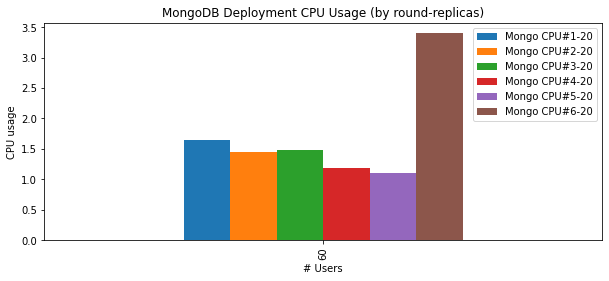

In [27]:
cpusDF = pd.DataFrame(cpuUsage, index=users)
# cpusDF.style
cpusDF.plot(kind="bar")
plt.title("MongoDB Deployment CPU Usage (by round-replicas)")
plt.xlabel("# Users")
plt.ylabel("CPU usage")
plt.rcParams["figure.figsize"] = (10,4)

In [28]:
memoryUsage = {}
for r in raw['#Replicas'].unique():
    kogitoMemoryUsageValues = raw[raw['#Replicas']==r]['Kogito Memory Usage'].values
    memoryUsage['Kogito Memory#'+str(r)] = kogitoMemoryUsageValues


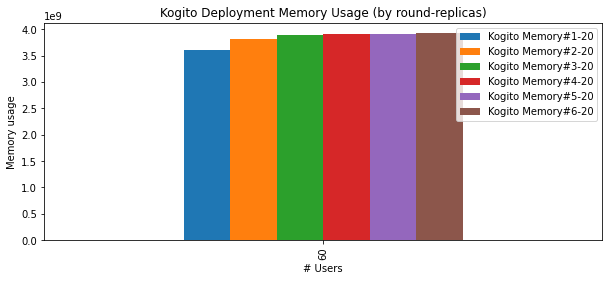

In [29]:
memoryUsageDF = pd.DataFrame(memoryUsage, index=users)
memoryUsageDF.plot(kind="bar")
plt.title("Kogito Deployment Memory Usage (by round-replicas)")
plt.xlabel("# Users")
plt.ylabel("Memory usage")
plt.rcParams["figure.figsize"] = (10,4)

In [30]:
memoryUsage = {}
for r in raw['#Replicas'].unique():
    mongoMemoryUsageValues = raw[raw['#Replicas']==r]['Mongo Memory Usage'].values
    memoryUsage['Mongo Memory#'+str(r)] = mongoMemoryUsageValues

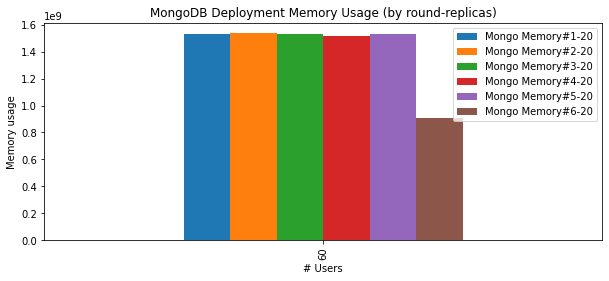

In [31]:
memoryUsageDF = pd.DataFrame(memoryUsage, index=users)
memoryUsageDF.plot(kind="bar")
plt.title("MongoDB Deployment Memory Usage (by round-replicas)")
plt.xlabel("# Users")
plt.ylabel("Memory usage")
plt.rcParams["figure.figsize"] = (10,4)

In [32]:
# combinedUsage = {}
# for r in raw['#Replicas'].unique():
#     appCpuUsageValues = raw[raw['#Replicas']==r]['CPU Usage-app'].str.replace('%','').apply(pd.to_numeric).values
#     systemCpuUsageValues = raw[raw['#Replicas']==r]['CPU Usage-system'].str.replace('%','').apply(pd.to_numeric).values
#     appMemoryUsageValues = raw[raw['#Replicas']==r]['Memory Usage%-app'].str.replace('%','').apply(pd.to_numeric).values
#     systemMemoryUsageValues = raw[raw['#Replicas']==r]['Memory Usage%-system'].str.replace('%','').apply(pd.to_numeric).values
#     combinedUsage['CPU%-app#'+str(r)] = appCpuUsageValues
#     combinedUsage['CPU%-sys#'+str(r)] = systemCpuUsageValues
#     combinedUsage['Memory%-app#'+str(r)] = appMemoryUsageValues
#     combinedUsage['Memory%-sys#'+str(r)] = systemMemoryUsageValues

In [33]:
# combinedUsageDF = pd.DataFrame(combinedUsage, index=users)
# combinedUsageDF.plot(kind="bar")
# plt.title("Resource usage")
# plt.xlabel("# Users")
# plt.ylabel("Usage")
# plt.rcParams["figure.figsize"] = (10,4)

### Tabular view

In [34]:
raw.style.hide_index().hide_columns(['Total CPUs', 'Total Memory GB', 'Start Time', 'End Time', 'Batch Duration',
    'Duration Single Test', 'App Process URL'])

Deployment,Persistence,#Replicas,#Users,MRT(ms),RPS,Failures%,Kogito CPU Usage,Mongo CPU Usage,Kogito Memory Usage,Mongo Memory Usage
Cloud,Mongo,1-20,60,42,1391,0,5.888654,1.645387,3604099072,1534304256
Cloud,Mongo,2-20,60,35,1646,1,2.975391,1.453888,3825303552,1538293760
Cloud,Mongo,3-20,60,36,1613,0,2.388171,1.486308,3894439936,1528766464
Cloud,Mongo,4-20,60,35,1663,12,1.936433,1.191827,3907862528,1520054272
Cloud,Mongo,5-20,60,35,1675,0,1.696525,1.099241,3913887744,1533530112
Cloud,Mongo,6-20,60,67,735,3,0.282293,3.402584,3927937024,910110720


In [35]:
downloadName=(deployment+'_'+startTime+'.csv').replace(':',"_").replace(' ',"_")
create_download_link(df=raw, filename=downloadName, title='Download detailed CSV report')